In [1]:
import numpy as np
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [3]:
from scipy.spatial.transform import Rotation

In [4]:
square_size = 2.0
img_mask = "../Chapitre 1/images/*.png"
pattern_size = (7, 9)

figsize = (20, 20)

img_names = glob(img_mask)
num_images = len(img_names)

pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
pattern_points *= square_size

obj_points = []
img_points = []
h, w = cv2.imread(img_names[0]).shape[:2]

In [5]:

keep_idxs=np.ones(num_images)
for i, fn in enumerate(img_names):
    


    img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2GRAY)

    
    found, corners = cv2.findChessboardCorners(img, pattern_size)  
    if not found:
        keep_idxs[i]=0
        print("chessboard not found")
        continue

    
    img_points.append(corners.reshape(-1, 2))
    obj_points.append(pattern_points)


img_names=[img_names[i] for i in range(num_images) if keep_idxs[i]==1]

chessboard not found


In [6]:
# calculate camera distortion
rms, camera_matrix, dist_coefs, _rvecs, _tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

print("\nRMS:", rms)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())


RMS: 2.479629261086798
camera matrix:
 [[3.04024857e+03 0.00000000e+00 1.48105062e+03]
 [0.00000000e+00 3.03447385e+03 2.01426083e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients:  [ 2.05853433e-01 -1.03426280e+00  7.20852043e-04 -4.77205455e-03
  1.33239975e+00]


In [7]:
all_pos=np.array([(-cv2.Rodrigues(_rvecs[i])[0].T).dot(_tvecs[i]) for i in range(len(_tvecs))]).reshape(-1,3)

In [8]:
x_max,y_max,z_max=np.max(np.concatenate((all_pos,pattern_points)),0)
x_min,y_min,z_min=np.min(np.concatenate((all_pos,pattern_points)),0)

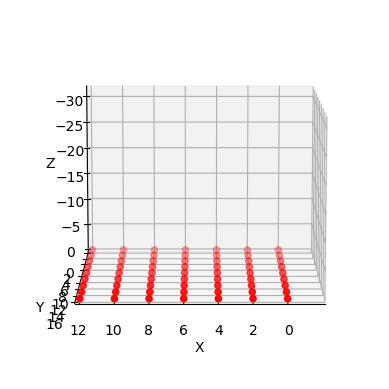

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10., azim=90)
ax.scatter(pattern_points[:,0], pattern_points[:,1], pattern_points[:,2], c='r', marker='o')
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)
ax.set_zlim(z_max,z_min)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

#ax.scatter(pos[0],pos[1],pos[2])
graph, = ax.plot([],[],[], c='b', marker='o')
x_line, = ax.plot( [0,0], [0,0], [0,0], c='lime')
y_line, = ax.plot( [0,0], [0,0], [0,0], c='red')
z_line, = ax.plot( [0,0], [0,0], [0,0], c='blue')


# créer un objet de tracé qui doit être animé
#graph, = ax.plot([],[],[], c='b', marker='o')
x_line, = ax.plot( [0,0], [0,0], [0,0], c='lime')
y_line, = ax.plot( [0,0], [0,0], [0,0], c='red')
z_line, = ax.plot( [0,0], [0,0], [0,0], c='blue')

# define the lines to represent the camera rotation
x_line_coords = [[1],[0],[0]]
y_line_coords = [[0],[1],[0]]
z_line_coords = [[0],[0],[1]]

def animate(i):
    # obtenir les matrices de projection en utilisant DLT
    rotation_object = Rotation.from_rotvec(_rvecs[i].reshape(-1))
    R = rotation_object.as_matrix()
    t=_tvecs[i].reshape(-1)
    
    # extraire la matrice de rotation et la transposer puisque nous voulons inverser le processus
    # nous devons également la multiplier par -1 car son déterminant ne serait pas égal à 1 
    # sinon, il ne s'agirait pas d'une matrice de rotation
    rot = -R.transpose()
    # appliquer la rotation à la partie de transplation de M pour récupérer la position de la caméra
    pos = np.matmul(rot,t)

    # appliquer la même rotation à la ligne utilisée pour représenter l'orientation de la caméra
    x_line_rot = np.matmul(rot,x_line_coords)[:,0]
    y_line_rot = np.matmul(rot,y_line_coords)[:,0]
    z_line_rot = np.matmul(rot,z_line_coords)[:,0]

    # définir les données pour l'animation
    #graph.set_data([pos[0],pos[1]], [pos[1],pos[1]])
    #graph.set_3d_properties([pos[1],pos[2]])
    x_line.set_data([pos[0], pos[0]+x_line_rot[0]], [pos[1], pos[1]+x_line_rot[1]])
    x_line.set_3d_properties([pos[2], pos[2]+x_line_rot[2]])
    
    y_line.set_data([pos[0], pos[0]+y_line_rot[0]], [pos[1], pos[1]+y_line_rot[1]])
    y_line.set_3d_properties([pos[2], pos[2]+y_line_rot[2]])
    
    z_line.set_data([pos[0], pos[0]+z_line_rot[0]], [pos[1], pos[1]+z_line_rot[1]])
    z_line.set_3d_properties([pos[2], pos[2]+z_line_rot[2]])

# run and save animation
anim = FuncAnimation(fig, animate, frames=len(img_names), interval=20)


In [10]:

anim.save(filename="courbe2.mp4", dpi =80, fps=1)



<source src="courbe.mp4" type="video/mp4" />

In [11]:
%%html

<video width="800" height="400" controls="controls">
  <source src="courbe2.mp4" type="video/mp4" />
</video>